# Denoising filter testing
## required libaries

In [1]:
import os, cv2, time, multiprocessing
import numpy as np
import matplotlib.pyplot as plt

import functions as f

home_dir = os.path.abspath("")

## load file

In [2]:
#filepath_noisy = filedialog.askopenfilename(title='Please select the image',filetypes=[("Tiff images", "*.tif;*.tiff")])
file_name = '84d tiff'
tiff_file = home_dir + os.sep + file_name + '.tif'
CT = f.CTPreprocessor(tiff_file)

Dimensions: z = 1510, h = 1905, w = 1908 [px]


## Show the loaded images

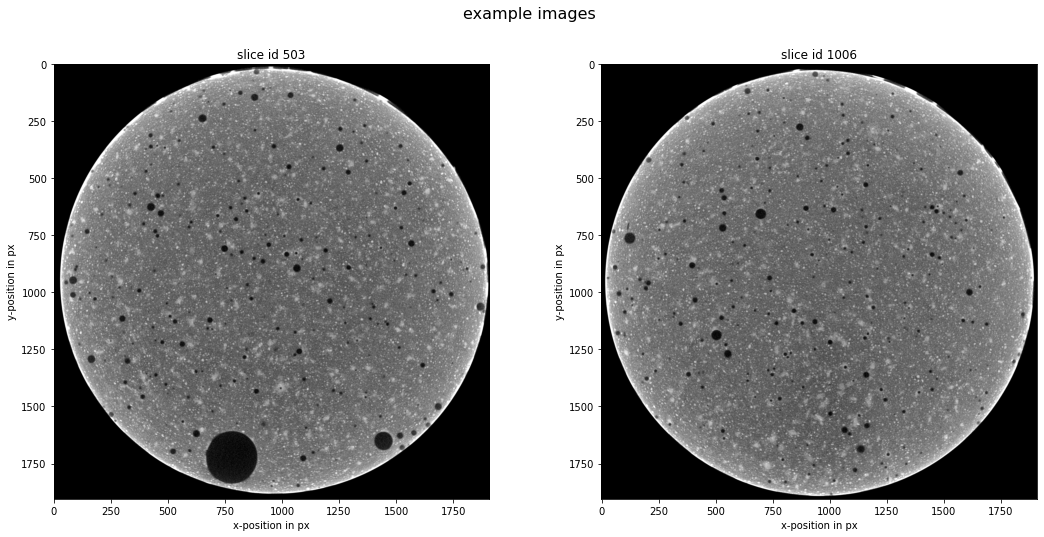

In [3]:
CT.show_example_slices()

## process the main circle, its center point and the inner pores and fix background based on individual slices

slice 0 start


e:\GIT\CT_edge_hardening_remover\functions.py:16: RuntimeWarning: overflow encountered in power
  return c + d**(d**((x-x0)/b))


slice 0 done


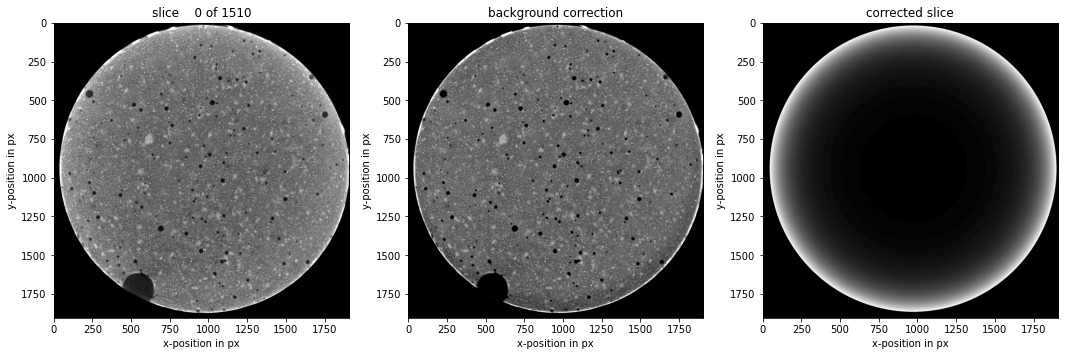

Splitting slice processing in 1 processes.
The processing of each slice may take around 3.4 seconds
The overall process may take 86.5 minutes
slice 50 start
slice 50 done
slice 100 start
slice 100 done
slice 150 start
slice 150 done
slice 200 start
slice 200 done
slice 250 start
slice 250 done
slice 300 start
slice 300 done
slice 350 start
slice 350 done
slice 400 start
slice 400 done
slice 450 start
slice 450 done
slice 500 start
slice 500 done
slice 550 start
slice 550 done
slice 600 start
slice 600 done
slice 650 start
slice 650 done
slice 700 start
slice 700 done
slice 750 start
slice 750 done
slice 800 start
slice 800 done
slice 850 start
slice 850 done
slice 900 start
slice 900 done
slice 950 start
slice 950 done
slice 1000 start
slice 1000 done
slice 1050 start
slice 1050 done
slice 1100 start
slice 1100 done
slice 1150 start
slice 1150 done
slice 1200 start
slice 1200 done
slice 1250 start
slice 1250 done
slice 1300 start
slice 1300 done
slice 1350 start
slice 1350 done
slice 1

In [4]:
circle_radii     = np.empty((CT.z,) , dtype = np.int16 )
circle_max_radii = np.empty((CT.z,) , dtype = np.int16 )
circle_centers   = np.empty((CT.z,2), dtype = np.int32 )
pore_areas	     = np.empty((CT.z,) , dtype = np.float64 )

fixed_volume   = np.empty(shape=CT.dataset.shape, dtype=np.uint8)
bg_diff_volume = np.empty(shape=CT.dataset.shape, dtype=np.uint8)


def process_slice(id, slice):
	if id%50 == 0: print("slice {:d} start".format(id))

	slice.identify_main_circle(verbose=False)
	slice.get_main_circle()
	slice.identify_pores()

	CT.slice.remove_pores()
	
	fit_data, bg_diff_volume, background, fixed_volume = slice.fix_background( iterations= 2, verbose_level = 0 )
	#fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )
	return {'id'            : id,
			'min_length'    : slice.min_length, 
	 		'radius'        : slice.radius,
	 		'center'        : slice.center,
	 		'pore_area'     : slice.pore_area_percent*100,
	 		'bg_diff_volume': bg_diff_volume,
	 		'fixed_volume'  : fixed_volume
			}

def process_slice_cb(r):
	id = r['id']
	circle_max_radii[id]   = r['min_length']     # not really r
	circle_radii[id]       = r['radius']         # actual radius
	circle_centers[id]     = r['center']         # x and y position of the identified circle
	pore_areas[id]         = r['pore_area']      # porea area percentage
	fixed_volume[id]       = r['bg_diff_volume'] # the processed backgrounds as a volume
	bg_diff_volume[id]     = r['fixed_volume']   # corrected dataset
	if id%50 == 0: print("slice {:d} done".format(id))

# benchmark a singe slice
CT.select_slice(0)
time_start = time.time()
r = process_slice( 0, CT.slice )
process_slice_cb( r )
duration = time.time() - time_start

fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].imshow( CT.slice.slice, cmap='gray' )
ax[0].set_title( "slice{: 5d} of{: 5d}".format(0, CT.z) )
ax[0].set_xlabel("x-position in {}".format( CT.unit ))
ax[0].set_ylabel("y-position in {}".format( CT.unit ))

ax[1].imshow( bg_diff_volume[0], cmap='gray' )
ax[1].set_title( "background correction" )
ax[1].set_xlabel("x-position in {}".format( CT.unit ))
ax[1].set_ylabel("y-position in {}".format( CT.unit ))

ax[2].imshow( fixed_volume[0], cmap='gray' )
ax[2].set_title( "corrected slice" )
ax[2].set_xlabel("x-position in {}".format( CT.unit ))
ax[2].set_ylabel("y-position in {}".format( CT.unit ))

plt.show()

coreCount = 1#multiprocessing.cpu_count()
processCount = (coreCount - 2) if coreCount > 2 else 1
print('Splitting slice processing in {:d} processes.'.format(processCount))
print('The processing of each slice may take around {:.1f} seconds'.format(duration))
print('The overall process may take {:.1f} minutes'.format(duration*CT.z/processCount/60))

pool = multiprocessing.Pool( processes = processCount )
for i in range( 1, CT.z ):
	CT.select_slice(i)
	if processCount == 1:
		r = process_slice( i, CT.slice )
		process_slice_cb( r )
	else:
		r = pool.apply_async(process_slice, args=( i, CT.slice ), callback=process_slice_cb)

pool.close() # close the process pool
pool.join()  # wait for all tasks to finish

circle_centers = np.swapaxes(circle_centers,0,1)
min_pore_pos   = np.argmin(pore_areas)

In [11]:
print(fixed_volume.shape)

(1510, 1905, 1908)


In [9]:
file_name = '84d tiff'
cv2.imwrite( home_dir + os.sep + file_name + '_fixed.tif', fixed_volume)
cv2.imwrite( home_dir + os.sep + file_name + '_bg.tif', bg_diff_volume);

False

In [5]:
"""

time_start = time.time()
for i in range( CT.z ):
	#if i%100 == 0: print("slice{: 5d} of{: 5d}".format(i, CT.z))
	CT.select_slice(i)

	CT.slice.identify_main_circle(verbose=False)
	CT.slice.get_main_circle()
	CT.slice.identify_pores()
	
	circle_max_radii[i]   = CT.slice.min_length    # not really r
	circle_radii[i]   	  = CT.slice.radius    # not really r
	circle_centers[i]     = CT.slice.center
	pore_areas[i]         = CT.slice.pore_area_percent*100

	CT.slice.remove_pores()
	
	fit_data, bg_diff_volume[i], background, fixed_volume[i] = CT.fix_background( iterations= 2, verbose_level = 0 )
	#fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )

	if i%50 == 0:
		time_end = time.time()
		print("slice{: 5d} of{: 5d} ({:.1f} s)".format(i, CT.z, time_end-time_start))
		time_start = time_end
	if i%250 == 0:
		fig, ax = plt.subplots(1,3, figsize=(18,6))
		ax[0].imshow( CT.slice, cmap='gray' )
		ax[0].set_title( "slice{: 5d} of{: 5d}".format(i, CT.z) )
		ax[1].imshow( bg_diff_volume[i], cmap='gray' )
		ax[1].set_title( "background correction" )
		ax[2].imshow( fixed_volume[i], cmap='gray' )
		ax[2].set_title( "corrected slice" )
		plt.show()

	
circle_centers = np.swapaxes(circle_centers,0,1)

min_pore_pos = np.argmin(pore_areas)

"""

'\n\ntime_start = time.time()\nfor i in range( CT.z ):\n\t#if i%100 == 0: print("slice{: 5d} of{: 5d}".format(i, CT.z))\n\tCT.select_slice(i)\n\n\tCT.slice.identify_main_circle(verbose=False)\n\tCT.slice.get_main_circle()\n\tCT.slice.identify_pores()\n\t\n\tcircle_max_radii[i]   = CT.slice.min_length    # not really r\n\tcircle_radii[i]   \t  = CT.slice.radius    # not really r\n\tcircle_centers[i]     = CT.slice.center\n\tpore_areas[i]         = CT.slice.pore_area_percent*100\n\n\tCT.slice.remove_pores()\n\t\n\tfit_data, bg_diff_volume[i], background, fixed_volume[i] = CT.fix_background( iterations= 2, verbose_level = 0 )\n\t#fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )\n\n\tif i%50 == 0:\n\t\ttime_end = time.time()\n\t\tprint("slice{: 5d} of{: 5d} ({:.1f} s)".format(i, CT.z, time_end-time_start))\n\t\ttime_start = time_end\n\tif i%250 == 0:\n\t\

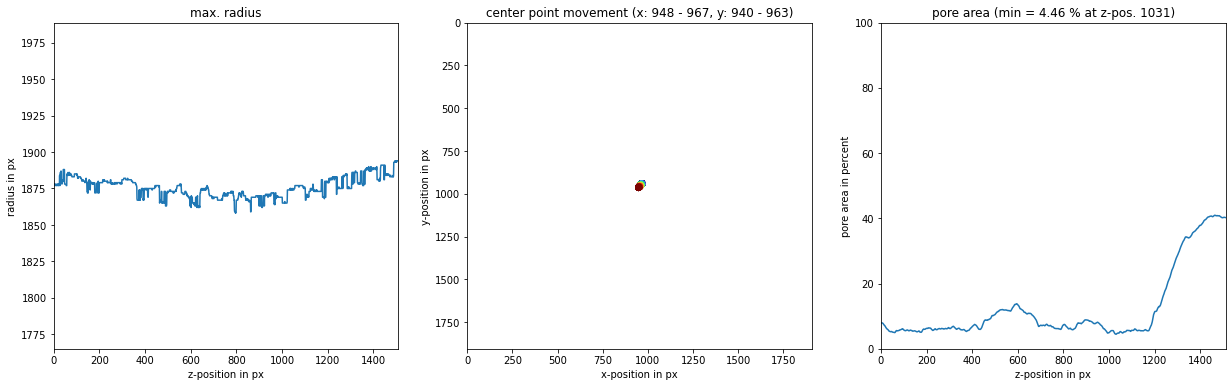

In [6]:
fig, ax = plt.subplots(1,3, figsize=(21,6))

ax[0].plot( range(CT.z), circle_radii )
ax[0].set_xlim((0, CT.z))
ax[0].set_ylim((circle_radii.min()*0.95, circle_radii.max()*1.05))
ax[0].set_title( "max. radius" )
ax[0].set_xlabel("z-position in {}".format(CT.unit))
ax[0].set_ylabel("radius in {}".format(CT.unit))

ax[1].scatter(circle_centers[0], circle_centers[1], c=range(CT.z), cmap='turbo')
ax[1].set_xlim((0, CT.w))
ax[1].set_ylim((CT.h, 0))
ax[1].set_title( "center point movement (x: {:d} - {:d}, y: {:d} - {:d})".format(circle_centers[0].min(), circle_centers[0].max(), circle_centers[1].min(), circle_centers[1].max()) )
ax[1].set_xlabel("x-position in {}".format(CT.unit))
ax[1].set_ylabel("y-position in {}".format(CT.unit))

ax[2].plot( range(CT.z), pore_areas )
ax[2].set_title( "pore area (min = {:.2f} % at z-pos. {:d})".format(pore_areas[min_pore_pos], min_pore_pos) )
ax[2].set_xlim((0, CT.z))
ax[2].set_ylim((0, 100))
ax[2].set_xlabel("z-position in {}".format(CT.unit))
ax[2].set_ylabel("pore area in percent")

plt.show()

In [7]:
raise SystemExit('Stopping execution')

SystemExit: Stopping execution

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# process stack based on a single background fix
- delivers inconsistent results

In [ ]:
CT.select_slice(min_pore_pos)

CT.identify_main_circle(verbose=False)
CT.get_main_circle()

CT.identify_pores()
CT.remove_pores();

found the center point at (954, 956). The circle has a maximum radius of 949 px.


In [ ]:
fit_data, background_difference, background, fixed = CT.fix_background( iterations= 3, verbose_level = 0 )

e:\GIT\CT_edge_hardening_remover\functions.py:16: RuntimeWarning: overflow encountered in power
  return c + d**(d**((x-x0)/b))


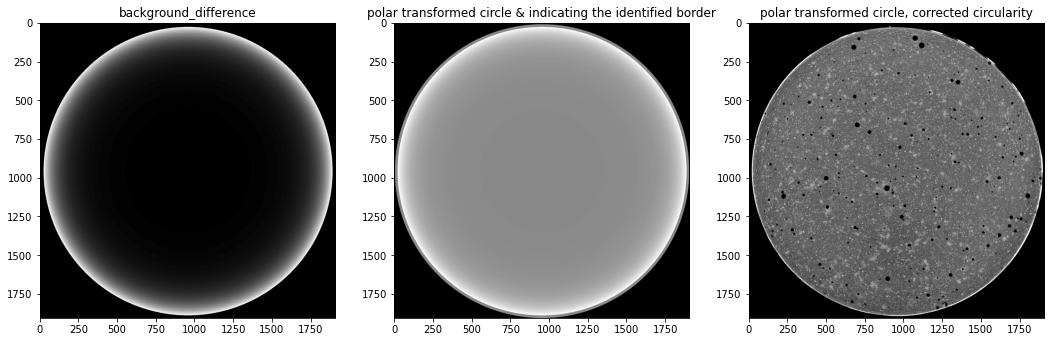

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow( background_difference, cmap='gray' )
ax[0].set_title( "background_difference" )
ax[1].imshow( background, cmap='gray' )
ax[1].set_title( "polar transformed circle & indicating the identified border" )
ax[2].imshow( fixed, cmap='gray' )
ax[2].set_title( "polar transformed circle, corrected circularity" )
plt.show()

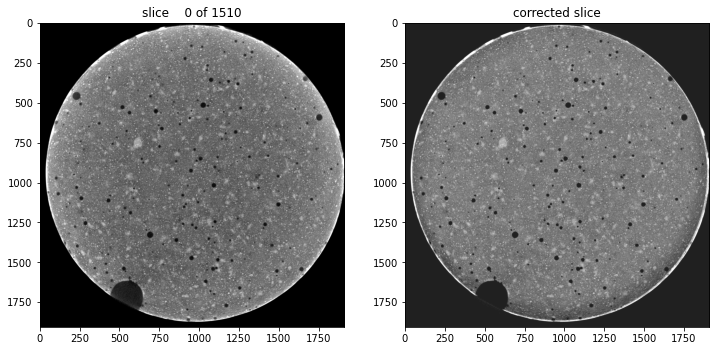

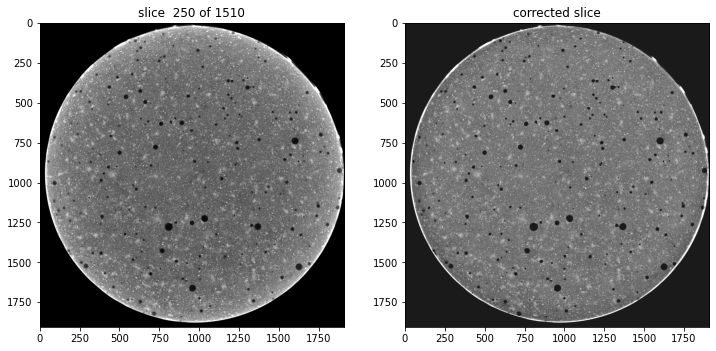

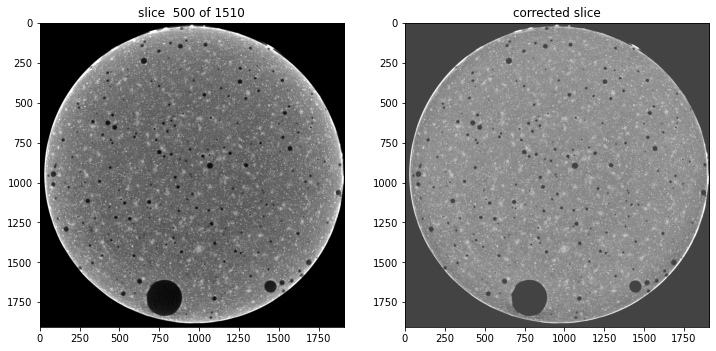

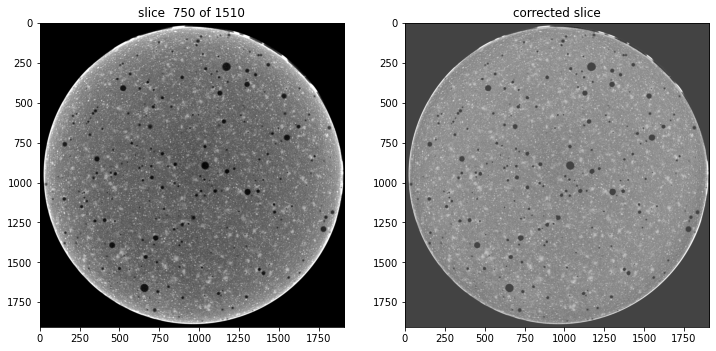

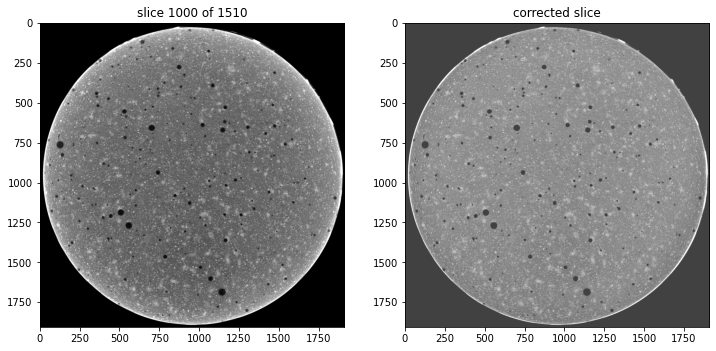

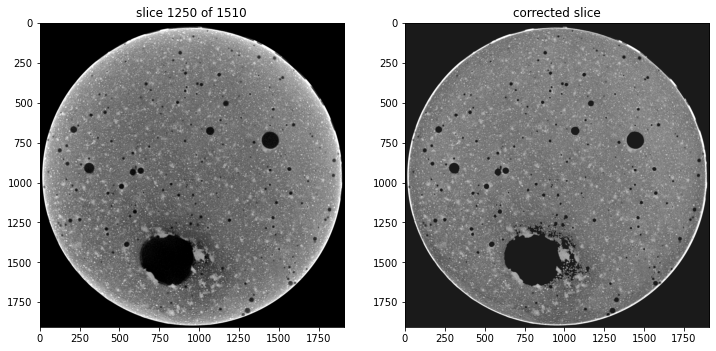

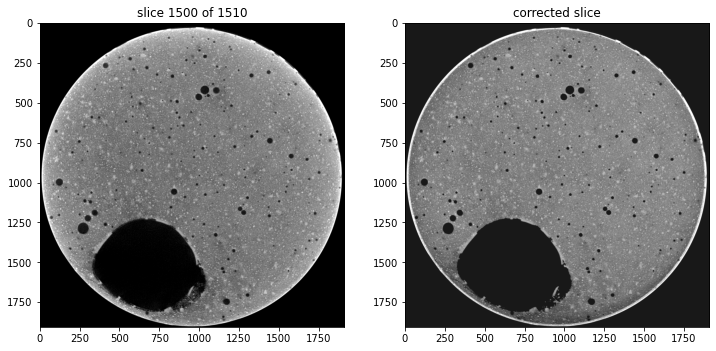

: 

In [ ]:
# polar_background
fixed_volume = np.empty(shape=CT.dataset.shape)
for i in range( CT.z ):
	CT.select_slice(i)
	CT.identify_main_circle(verbose=False)
	CT.get_main_circle()
	CT.identify_pores()
	
	fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )

	if i%50 == 0: print("slice{: 5d} of{: 5d}".format(i, CT.z))
	if i%250 == 0:
		fig, ax = plt.subplots(1,2, figsize=(12,6))
		ax[0].imshow( CT.slice, cmap='gray' )
		ax[0].set_title( "slice{: 5d} of{: 5d}".format(i, CT.z) )
		ax[1].imshow( fixed_volume[i], cmap='gray' )
		ax[1].set_title( "corrected slice" )
		plt.show()